# Policy-based agent in the cart-pole environment using Apple MLX

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [1]:
import time
import imageio
import mlx.core as mx
import gymnasium as gym
import mlx.optimizers as optim
import matplotlib.pyplot as plt

from policy_simple import PolicyGradient

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

### Training

#### Parameters

In [3]:
GAMES = 4000

NETWORK = {"inputs": 4, "outputs": 2, "nodes": [30, 15]}
OPTIMIZER = {"optimizer": optim.RMSprop, "lr": 0.00025}

#### Initialisation

In [4]:
policy_agent = PolicyGradient(
    network=NETWORK, optimizer=OPTIMIZER
)

checkpoint = GAMES // 10
metrics = {metric: mx.zeros(GAMES) for metric in ["steps", "gradient"]}

#### Training

In [5]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = mx.array(environment.reset()[0])                                                  # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action = policy_agent.action(state)
        new_state, reward, terminated, truncated, _ = environment.step(action)
        
        policy_agent.memorize(state, action, reward)
        
        state = mx.array(new_state)
    gradient = policy_agent.learn()
    
    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["gradient"][game-1] = gradient
    
    if game % checkpoint == 0 or game == GAMES:

        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean().item()
        _mean_gradient = metrics["gradient"][max(0, game-checkpoint-1):game-1].mean().item()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average gradients: {_mean_gradient:>8.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game    400               10 % 
------------------------------ 
 > Average steps:           22 
 > Average gradients:  -0.4405 
 
Game    800               20 % 
------------------------------ 
 > Average steps:           29 
 > Average gradients:  -1.0376 
 
Game   1200               30 % 
------------------------------ 
 > Average steps:           52 
 > Average gradients:  -1.4220 
 
Game   1600               40 % 
------------------------------ 
 > Average steps:          123 
 > Average gradients:  -1.8816 
 
Game   2000               50 % 
------------------------------ 
 > Average steps:          207 
 > Average gradients:  -1.6253 
 
Game   2400               60 % 
------------------------------ 
 > Average steps:          331 
 > Average gradients:  -1.2363 
 
Game   2800               70 % 
------------------------------ 
 > Average steps:          393 
 > Average gradients:  -0.9425 
 
Game   3200               80 % 
------------------------------ 
 > Average steps:         

#### Visualisation

##### Metrics

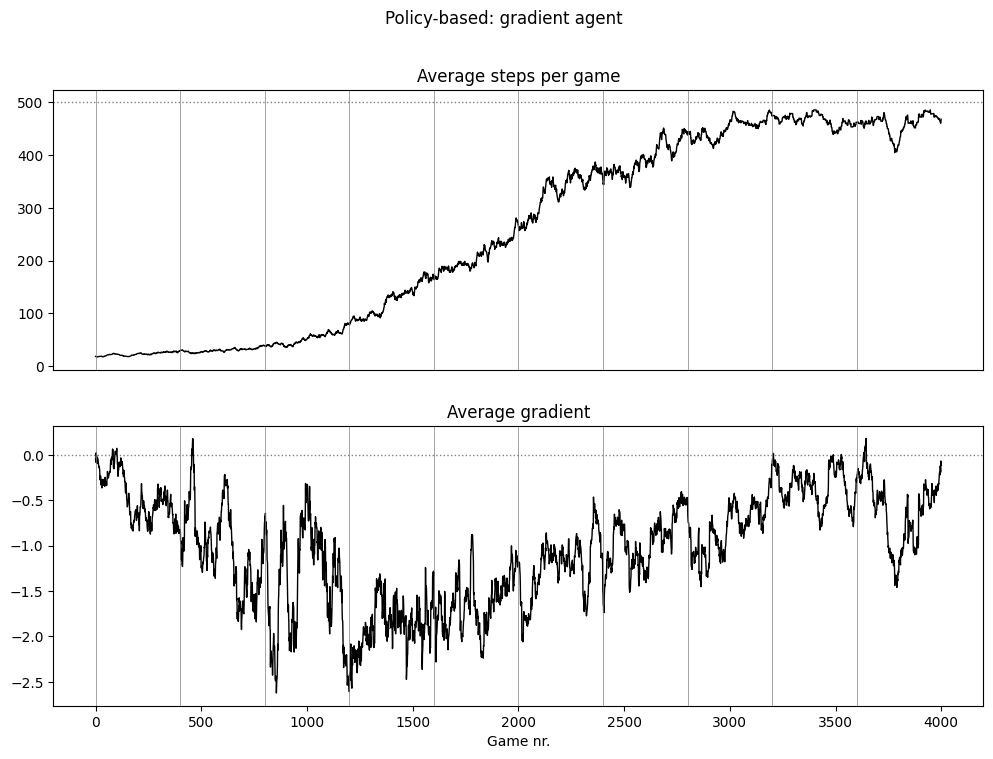

In [6]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(GAMES, i+half_window)]).mean().item() 
            for i in range(GAMES)]

steps = moving_average(metrics["steps"])
gradients = moving_average(metrics["gradient"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Policy-based: gradient agent")

ax[0].axhline(y=500, color="gray", linestyle="dotted", linewidth=1)
ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].axhline(y=0, color="gray", linestyle="dotted", linewidth=1)
ax[1].plot(gradients, color="black", linewidth=1)
ax[1].set_xlabel("Game nr.")
ax[1].set_title("Average gradient")

for i in range(0, GAMES, GAMES // 10):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)

plt.savefig("../../output/mlx-policy-cartpole.png")
plt.show()

##### In action

In [8]:
state = mx.array(environment.reset()[0])

images = []
terminated = truncated = False
while not (terminated or truncated):
    actions = mx.softmax(policy_agent.agent(state))
    action = mx.argmax(actions).item()
    
    state, reward, terminated, truncated, _ = environment.step(action)
    state = mx.array(state)

    images.append(environment.render())
_ = imageio.mimsave('../../output/mlx-policy-cartpole.gif', images, duration=25)

<img src="../../output/mlx-policy-cartpole.gif" width="1000" height="1000" />

In [ ]:
environment.close()